In [5]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

# import os
# import sys
# module_path = os.path.abspath(os.path.join('./.')) # or the path to your source code
# print(module_path)
# sys.path.append(module_path)

# from our_lib import *

In [68]:
import os
import sys
# module_path = os.path.abspath(os.path.join('./.')) # or the path to your source code
module_path = os.path.abspath(os.path.join('../.')) # or the path to your source code
print(module_path)
sys.path.append(module_path)
# module_path = os.path.abspath(os.path.join('../.')) # or the path to your source code
module_path = os.path.abspath(os.path.join('../recsys2025')) # or the path to your source code
# module_path = os.path.abspath(os.path.join('../recsys2025')) # or the path to your source code
print(module_path)
sys.path.append(module_path)

from recsys2025.validator.validate import validate_and_load_embeddings

# import recsys2025.data_utils.validate_and_load_embeddings
validate_and_load_embeddings

/home/zmrocze/studia/uwr/sem2/adm/projekt
/home/zmrocze/studia/uwr/sem2/adm/projekt/recsys2025


<function recsys2025.validator.validate.validate_and_load_embeddings(input_dir: pathlib._local.Path, embeddings_dir: pathlib._local.Path, max_embedding_dim: int, disable_relevant_clients_check: bool) -> Tuple[numpy.ndarray, numpy.ndarray]>

In [ ]:
import subprocess
from pathlib import Path

# recsys2025
# ! PYTHONPATH=$PYTHONPATH:../recsys2025 python -m data_utils.split_data --challenge-data-dir ../ubc_data_dirty
def split_data(challenge_data_dir):
  """
  Call the data_utils.split_data module with the specified challenge data directory.
  
  Args:
    challenge_data_dir (str): Path to the challenge data directory
  """
  here = Path.cwd()
  challenge_data_dir = str((here / challenge_data_dir).resolve())
  cmd = [
    'python', '-m', 'data_utils.split_data', 
    '--challenge-data-dir', challenge_data_dir
  ]

  return run_recsys_command(cmd)

# ! PYTHONPATH=$PYTHONPATH:../recsys2025 python -m baseline.aggregated_features_baseline.create_embeddings --data-dir ../ubc_data_dirty/ --embeddings-dir ../baseline_embeddings --num-days 1 7 30
def create_baseline_embeddings(data_dir, embeddings_dir, num_days=[1, 7, 30], top_n=None):
  """
  Call the baseline.aggregated_features_baseline.create_embeddings module with the specified parameters.
  
  --data-dir DATA_DIR   Directory with input and target data produced by data_utils.split_data
  --embeddings-dir EMBEDDINGS_DIR
                        Directory where to store generated embeddings
  --num-days [NUM_DAYS ...]
                        Numer of days to compute features
  --top-n TOP_N         Number of top column values to consider in feature generation
  """
  here = Path.cwd()
  data_dir = str((here / Path(data_dir)).resolve())
  embeddings_dir = str((here / Path(embeddings_dir)).resolve())
  cmd = [
    'python', '-m', 'baseline.aggregated_features_baseline.create_embeddings',
    '--data-dir', data_dir,
    '--embeddings-dir', embeddings_dir,
    '--num-days'
  ] + [str(day) for day in num_days] + (['--top-n', str(top_n)] if top_n else [])
  
  return run_recsys_command(cmd)

# python -m training_pipeline.train --data-dir <your_splitted_challenge_data_dir> --embeddings-dir <your-embeddings-dir> --tasks churn propensity_category propensity_sku --log-name <my_experiment> --accelerator gpu --devices 0 --neptune-api-token <your-api-token> --neptune-project <your-worskspace>/<your-project> --disable-relevant-clients-check
def contest_training(data_dir, embeddings_dir, score_dir, disable_relevant_clients_check=False, accelerator="gpu", devices="0", num_workers=None , tasks=None, log_name="my_experiment",  neptune_api_token=None, neptune_project=None):
  """
  Call the training_pipeline.train module with the specified parameters.
  
  Args:
    --data-dir DATA_DIR   Directory where target and input data are stored
    --embeddings-dir EMBEDDINGS_DIR
                          Directory where input embeddings are stored
    --tasks TASKS [TASKS ...]
                          Name of the task to train out of: churn propensity_category propensity_sku
    --log-name LOG_NAME   Experiment name
    --num-workers NUM_WORKERS
                          Number of subprocesses to use for data loading
    --accelerator ACCELERATOR
                          Accelerator type
    --devices [DEVICES ...]
                          List of devices to use. Possible options: "auto", id of single device to use or list of ids
                          of devices to use.
    --neptune-api-token NEPTUNE_API_TOKEN
                          Neptune API token.
    --neptune-project NEPTUNE_PROJECT
                          Name of Neptune project within workspace to save result to.
    --score-dir SCORE_DIR
                          Path to directory where to save best scores for each task
    --disable-relevant-clients-check
                          Disables relevant clients check in validator, but enables embeddings for sets of clients
                          other than relevant clients.
  """
  if tasks is None:
    tasks = ['churn', 'propensity_category', 'propensity_sku']
  
  here = Path.cwd()
  data_dir = str((here / Path(data_dir)).resolve())
  embeddings_dir = str((here / Path(embeddings_dir)).resolve())
  score_dir = str((here / Path(score_dir)).resolve())
  
  cmd = [
    'python', '-m', 'training_pipeline.train',
    '--data-dir', data_dir,
    '--embeddings-dir', embeddings_dir,
    '--tasks'
  ] + tasks + (['--num-workers', str(num_workers)] if num_workers else []) + [
    '--log-name', log_name,
    '--accelerator', accelerator,
    '--devices', devices
  ]
  
  if neptune_api_token:
    cmd.extend(['--neptune-api-token', neptune_api_token])
  
  if neptune_project:
    cmd.extend(['--neptune-project', neptune_project])
  
  if disable_relevant_clients_check:
    cmd.append('--disable-relevant-clients-check')
  
  return run_recsys_command(cmd)

recsys_path = (Path.cwd() / '../recsys2025').resolve()

def run_recsys_command(cmd):
  env = os.environ.copy()
  env['PYTHONPATH'] = f"{env.get('PYTHONPATH', '')}:{str(recsys_path)}"

  print(f"Running command: {' '.join(cmd)}")
  print(f"recsys_path: {recsys_path}")

  result = subprocess.run(cmd, env=env, capture_output=True, text=True)
  
  if result.stdout:
    print(f"Stdout: {result.stdout}")
  if result.stderr:
    print(f"Stderr: {result.stderr}")
  if result.returncode != 0:
    print("Command failed!")
  
  return result

In [72]:
split_data('../ubc_data_dirty')

Running command: python -m data_utils.split_data --challenge-data-dir /home/zmrocze/studia/uwr/sem2/adm/projekt/ubc_data_dirty
recsys_path: /home/zmrocze/studia/uwr/sem2/adm/projekt/recsys2025
Stderr: INFO:__main__:Creating splits for product_buy event type
INFO:__main__:Creating splits for add_to_cart event type
INFO:__main__:Creating splits for remove_from_cart event type
INFO:__main__:Creating splits for page_visit event type
INFO:__main__:Creating splits for search_query event type
INFO:__main__:Saving product_buy train input
INFO:__main__:Saving add_to_cart train input
INFO:__main__:Saving remove_from_cart train input
INFO:__main__:Saving page_visit train input
INFO:__main__:Saving search_query train input
INFO:__main__:Saving train_target
INFO:__main__:Saving validation_target



CompletedProcess(args=['python', '-m', 'data_utils.split_data', '--challenge-data-dir', '/home/zmrocze/studia/uwr/sem2/adm/projekt/ubc_data_dirty'], returncode=0, stdout='', stderr='INFO:__main__:Creating splits for product_buy event type\nINFO:__main__:Creating splits for add_to_cart event type\nINFO:__main__:Creating splits for remove_from_cart event type\nINFO:__main__:Creating splits for page_visit event type\nINFO:__main__:Creating splits for search_query event type\nINFO:__main__:Saving product_buy train input\nINFO:__main__:Saving add_to_cart train input\nINFO:__main__:Saving remove_from_cart train input\nINFO:__main__:Saving page_visit train input\nINFO:__main__:Saving search_query train input\nINFO:__main__:Saving train_target\nINFO:__main__:Saving validation_target\n')

In [73]:
create_baseline_embeddings('../ubc_data_dirty', '../baseline_embeddings')

Running command: python -m baseline.aggregated_features_baseline.create_embeddings --data-dir /home/zmrocze/studia/uwr/sem2/adm/projekt/ubc_data_dirty --embeddings-dir /home/zmrocze/studia/uwr/sem2/adm/projekt/baseline_embeddings --num-days 1 7 30
recsys_path: /home/zmrocze/studia/uwr/sem2/adm/projekt/recsys2025
Stderr: INFO:__main__:Generating features for product_buy event type
INFO:__main__:Loading data...
INFO:__main__:Generating features...

100%|██████████| 416269/416269 [01:16<00:00, 5432.53it/s]
INFO:__main__:Generating features for add_to_cart event type
INFO:__main__:Loading data...
INFO:__main__:Generating features...

100%|██████████| 496756/496756 [01:34<00:00, 5252.41it/s]
INFO:__main__:Generating features for remove_from_cart event type
INFO:__main__:Loading data...
INFO:__main__:Generating features...

100%|██████████| 253428/253428 [00:49<00:00, 5074.11it/s]
INFO:__main__:Generating features for page_visit event type
INFO:__main__:Loading data...
INFO:__main__:Generati

CompletedProcess(args=['python', '-m', 'baseline.aggregated_features_baseline.create_embeddings', '--data-dir', '/home/zmrocze/studia/uwr/sem2/adm/projekt/ubc_data_dirty', '--embeddings-dir', '/home/zmrocze/studia/uwr/sem2/adm/projekt/baseline_embeddings', '--num-days', '1', '7', '30'], returncode=0, stdout='', stderr='INFO:__main__:Generating features for product_buy event type\nINFO:__main__:Loading data...\nINFO:__main__:Generating features...\n\n  0%|          | 0/416269 [00:00<?, ?it/s]\n  0%|          | 60/416269 [00:00<11:33, 599.91it/s]\n  0%|          | 596/416269 [00:00<02:02, 3399.64it/s]\n  0%|          | 1174/416269 [00:00<01:32, 4485.50it/s]\n  0%|          | 1763/416269 [00:00<01:22, 5038.33it/s]\n  1%|          | 2348/416269 [00:00<01:17, 5328.03it/s]\n  1%|          | 2913/416269 [00:00<01:16, 5433.59it/s]\n  1%|          | 3457/416269 [00:00<01:15, 5432.58it/s]\n  1%|          | 4001/416269 [00:00<01:16, 5423.79it/s]\n  1%|          | 4595/416269 [00:00<01:13, 5583.59

In [ ]:
contest_training('../ubc_data_dirty', '../baseline_embeddings', '../baseline_score', disable_relevant_clients_check=True, accelerator="cpu", devices="auto", num_workers=1)

Running command: python -m training_pipeline.train --data-dir /home/zmrocze/studia/uwr/sem2/adm/projekt/ubc_data_dirty --embeddings-dir /home/zmrocze/studia/uwr/sem2/adm/projekt/baseline_embeddings --tasks churn propensity_category propensity_sku --num-workers 1 --log-name my_experiment --accelerator cpu --devices auto --disable-relevant-clients-check
recsys_path: /home/zmrocze/studia/uwr/sem2/adm/projekt/recsys2025


In [ ]:
# recsys2025
# ! PYTHONPATH=$PYTHONPATH:../recsys2025 python -m data_utils.split_data --challenge-data-dir ../ubc_data_dirty

In [7]:

# ! PYTHONPATH=$PYTHONPATH:../recsys2025 python -m baseline.aggregated_features_baseline.create_embeddings --data-dir ../ubc_data_dirty/ --embeddings-dir ../baseline_embeddings --num-days 1 7 30

In [8]:
# import torchdata
# below would work on torchdata <= 9.0.0
# from torchdata.datapipes.iter import FileLister
# import torcharrow.dtypes as dt
# DTYPE = dt.Struct([dt.Field("Values", dt.int32)])
# source_dp = FileLister(".", masks="df*.parquet")
# parquet_df_dp = source_dp.load_parquet_as_df(dtype=DTYPE)

In [9]:
import pandas as pd

# Load the dataframes from parquet files
add_to_cart = pd.read_parquet('../ubc_data/add_to_cart.parquet')
page_visit = pd.read_parquet('../ubc_data/page_visit.parquet')
product_buy = pd.read_parquet('../ubc_data/product_buy.parquet')
product_properties = pd.read_parquet('../ubc_data/product_properties.parquet')
remove_from_cart = pd.read_parquet('../ubc_data/remove_from_cart.parquet')
search_query = pd.read_parquet('../ubc_data/search_query.parquet')

print(f"Add to cart shape: {add_to_cart.shape}")
print(f"Page visit shape: {page_visit.shape}")
print(f"Product buy shape: {product_buy.shape}")
print(f"Product properties shape: {product_properties.shape}")
print(f"Remove from cart shape: {remove_from_cart.shape}")
print(f"Search query shape: {search_query.shape}")
# Display the first few rows of each dataframe
print("\nAdd to cart sample:")
print(add_to_cart.head())
print("\nPage visit sample:")
print(page_visit.head())
print("\nProduct buy sample:")
print(product_buy.head())
print("\nProduct properties sample:")
print(product_properties.head())
print("\nRemove from cart sample:")
print(remove_from_cart.head())
print("\nSearch query sample:")
print(search_query.head())

Add to cart shape: (5235882, 3)
Page visit shape: (150713186, 3)
Product buy shape: (1682296, 3)
Product properties shape: (1197634, 4)
Remove from cart shape: (1697891, 3)
Search query shape: (9571258, 3)

Add to cart sample:
   client_id            timestamp      sku
0   17649961  2022-08-11 12:22:55  1398840
1     315805  2022-09-11 05:34:10  1434568
2     315805  2022-10-06 04:58:15   998226
3   16696114  2022-07-11 16:27:00    81192
4   10238779  2022-10-05 14:36:55  1475246

Page visit sample:
   client_id            timestamp       url
0   13906876  2022-07-13 10:37:45  12160626
1   13906876  2022-08-11 18:13:20   9464384
2    7825390  2022-05-26 10:28:05   3876331
3   13416433  2022-05-25 18:20:10  15017297
4   13416433  2022-06-03 20:03:20  13003066

Product buy sample:
   client_id            timestamp     sku
0   17649961  2022-07-23 20:15:25   18485
1   16696114  2022-07-11 16:31:30   81192
2   10238779  2022-05-29 19:35:40  510014
3   10238779  2022-05-29 19:38:05  510014


In [45]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Helper function to calculate interaction statistics
def calculate_interaction_stats(df, interaction_name):
  interactions_per_user = df.groupby('client_id').size()
  time_range = (df['timestamp'].min(), df['timestamp'].max())
  stats = {
    'name': interaction_name,
    'total_interactions': len(df),
    'total_users': len(interactions_per_user),
    'avg_interactions_per_user': interactions_per_user.mean(),
    'avg_interactions_squared_per_user': (interactions_per_user ** 2).mean(),
    'min_interactions_per_user': interactions_per_user.min(),
    'max_interactions_per_user': interactions_per_user.max(),
    'median_interactions_per_user': interactions_per_user.median(),
    'std_interactions_per_user': interactions_per_user.std(),
    'time_range': time_range
  }
  
  # Add product-related statistics if 'sku' column exists
  if 'sku' in df.columns:
    products_per_user = df.groupby('client_id')['sku'].nunique()
    stats.update({
      'unique_products': df['sku'].nunique(),
      'product_interactions': products_per_user.sum(),
      'avg_products_per_user': products_per_user.mean(),
      'avg_products_squared_per_user': (products_per_user ** 2).mean(),
      'min_products_per_user': products_per_user.min(),
      'max_products_per_user': products_per_user.max(),
      'median_products_per_user': products_per_user.median(),
      'std_products_per_user': products_per_user.std(),
    })
  
  return stats, interactions_per_user

# Helper function to plot distribution
def plot_interaction_distribution(interactions_per_user, title, subplot_pos=None):
  if subplot_pos:
    plt.subplot(subplot_pos)
  plt.hist(interactions_per_user, bins=50, alpha=0.7, edgecolor='black', log=True)
  plt.xlabel('Number of Interactions per User')
  plt.ylabel('Number of Users')
  plt.title(title)


class RecSysData:
  def __init__(self, add_to_cart, page_visit, product_buy, product_properties, remove_from_cart, search_query):
    self.add_to_cart = add_to_cart
    self.page_visit = page_visit
    self.product_buy = product_buy
    self.product_properties = product_properties
    self.remove_from_cart = remove_from_cart
    self.search_query = search_query
    self.set_datasets()
  
  def set_datasets(self):
    self.datasets = {
      'add_to_cart': self.add_to_cart,
      'page_visit': self.page_visit,
      'product_buy': self.product_buy,
      'product_properties': self.product_properties,
      'remove_from_cart': self.remove_from_cart,
      'search_query': self.search_query
    }
    self.user_indexed_datasets = {i:self.datasets[i] for i in self.datasets if i!='product_properties'}

  def __repr__(self):
    return (f"RecSysData(\n"
        f"  add_to_cart={len(self.add_to_cart)},\n"
        f"  page_visit={len(self.page_visit)},\n"
        f"  product_buy={len(self.product_buy)},\n"
        f"  product_properties={len(self.product_properties)},\n"
        f"  remove_from_cart={len(self.remove_from_cart)},\n"
        f"  search_query={len(self.search_query)},\n"

        f"  all users: {len(self.all_users_set())},\n"
        f"  all products: {len(self.all_products_set())}\n"
        f"  all urls: {len(self.all_urls_set())},\n"
        f")")

  def all_users_set(self):
    all_users = set(self.add_to_cart['client_id']).union(
        set(self.page_visit['client_id']),
        set(self.product_buy['client_id']),
        set(self.remove_from_cart['client_id']),
        set(self.search_query['client_id'])
    )
    return all_users
  
  def all_urls_set(self):
    all_urls = set(self.page_visit['url']).union(
        set(self.search_query['query'])
    )
    return all_urls

  def all_products_set(self):
    all_products = set(self.add_to_cart['sku']).union(
        set(self.product_buy['sku']),
        set(self.remove_from_cart['sku']),
    )
    return all_products

  def sampled_subset(self, sampled_users, reset_index=True):
    sampled_users_set = set(sampled_users)
    if reset_index:
      f = lambda x: x.reset_index(drop=True)
    else:
      f = lambda x: x
    a = RecSysData(
      f(self.add_to_cart[self.add_to_cart['client_id'].isin(sampled_users_set)]),
      f(self.page_visit[self.page_visit['client_id'].isin(sampled_users_set)]),
      f(self.product_buy[self.product_buy['client_id'].isin(sampled_users_set)]),
      self.product_properties,
      f(self.remove_from_cart[self.remove_from_cart['client_id'].isin(sampled_users_set)]),
      f(self.search_query[self.search_query['client_id'].isin(sampled_users_set)])
    )
    remaining_products = a.all_products_set()
    a.product_properties = a.product_properties[a.product_properties['sku'].isin(remaining_products)]
    a.set_datasets()
    return a

  def save_parquet(self, dir_path):
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    self.add_to_cart.to_parquet(os.path.join(dir_path, 'add_to_cart.parquet'), index=False)
    self.page_visit.to_parquet(os.path.join(dir_path, 'page_visit.parquet'), index=False)
    self.product_buy.to_parquet(os.path.join(dir_path, 'product_buy.parquet'), index=False)
    self.remove_from_cart.to_parquet(os.path.join(dir_path, 'remove_from_cart.parquet'), index=False)
    self.search_query.to_parquet(os.path.join(dir_path, 'search_query.parquet'), index=False)
  
  def print_datasets_stats_nicely(self, title_name):
    # Calculate statistics for all datasets
    title_name = title_name.upper()
    print(f"=== {title_name} STATISTICS ===")
    # all_stats = []
    all_distributions = []

    for name, df  in self.user_indexed_datasets.items():
      stats, distribution = calculate_interaction_stats(df, name)
      # all_stats.append(stats)
      all_distributions.append(distribution)
      
      print(f"\n{name}:")
      print(f"  Total interactions: {stats['total_interactions']:,}")
      print(f"  Total users: {stats['total_users']:,}")
      print(f"  Average interactions per user: {stats['avg_interactions_per_user']:.2f}")
      print(f"  Average interactions squared per user: {stats['avg_interactions_squared_per_user']:.2f}")
      print(f"  Min interactions per user: {stats['min_interactions_per_user']}")
      print(f"  Max interactions per user: {stats['max_interactions_per_user']:,}")
      print(f"  Median interactions per user: {stats['median_interactions_per_user']:.2f}")
      print(f"  Std interactions per user: {stats['std_interactions_per_user']:.2f}")
      print(f"  Time range: {stats['time_range'][0]} to {stats['time_range'][1]}")
      if 'unique_products' in stats:
        print(f"  Unique products: {stats['unique_products']:,}")
        print(f"  Product interactions: {stats['product_interactions']:,}")
        print(f"  Average products per user: {stats['avg_products_per_user']:.2f}")
        print(f"  Average products squared per user: {stats['avg_products_squared_per_user']:.2f}")
        print(f"  Min products per user: {stats['min_products_per_user']}")
        print(f"  Max products per user: {stats['max_products_per_user']:,}")
        print(f"  Median products per user: {stats['median_products_per_user']:.2f}")
        print(f"  Std products per user: {stats['std_products_per_user']:.2f}")

    # Plot distributions for full dataset
    plt.figure(figsize=(15, 10))
    for i, (distribution, (name, _)) in enumerate(zip(all_distributions, self.datasets.items())):
      plot_interaction_distribution(distribution, f'{name} Distribution', 231 + i)

    plt.tight_layout()
    plt.suptitle(f'{title_name}: Distribution of Interactions per User', y=1.02, fontsize=16)
    plt.show()


In [50]:
full_recsys = RecSysData(
    add_to_cart,
    page_visit,
    product_buy,
    product_properties,
    remove_from_cart,
    search_query
  )

=== FULL DATASET STATISTICS ===

add_to_cart:
  Total interactions: 5,235,882
  Total users: 1,874,391
  Average interactions per user: 2.79
  Average interactions squared per user: 62.22
  Min interactions per user: 1
  Max interactions per user: 1,731
  Median interactions per user: 1.00
  Std interactions per user: 7.38
  Time range: 2022-05-23 00:10:15 to 2022-10-10 23:59:10
  Unique products: 1,120,342
  Product interactions: 4,067,613
  Average products per user: 2.17
  Average products squared per user: 32.01
  Min products per user: 1
  Max products per user: 1,032
  Median products per user: 1.00
  Std products per user: 5.22

page_visit:
  Total interactions: 150,713,186
  Total users: 18,614,702
  Average interactions per user: 8.10
  Average interactions squared per user: 1874.33
  Min interactions per user: 1
  Max interactions per user: 28,479
  Median interactions per user: 2.00
  Std interactions per user: 42.53
  Time range: 2022-05-23 00:10:00 to 2022-10-10 23:59:59



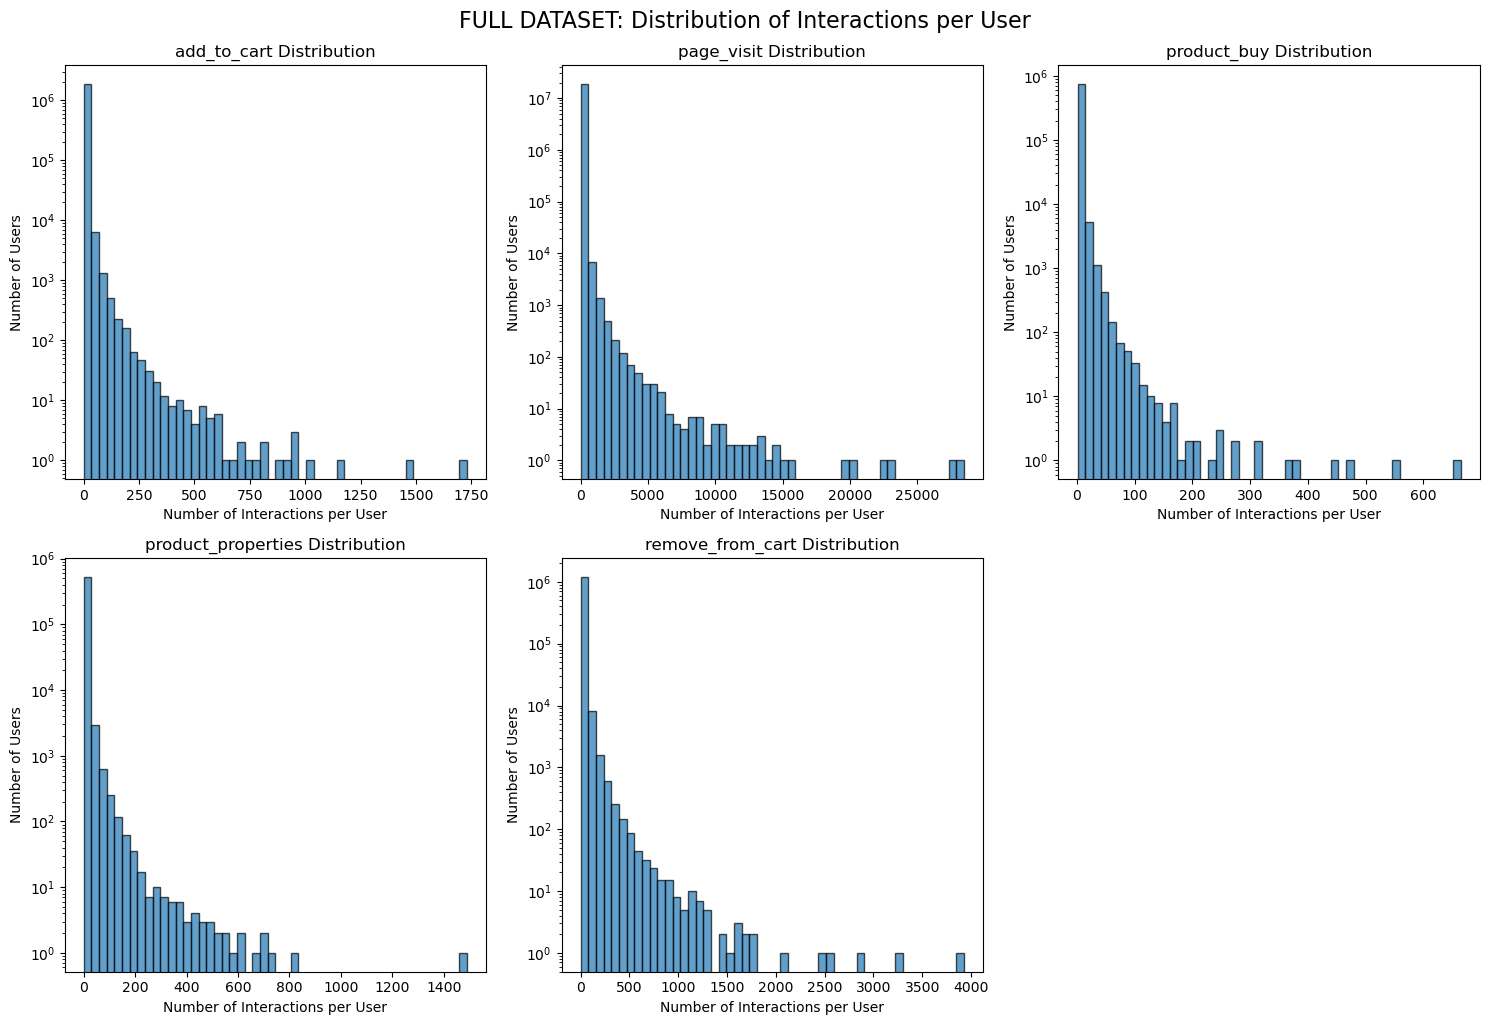

In [47]:
full_recsys.print_datasets_stats_nicely("Full Dataset")

Total unique users across all datasets: 18,889,063
=== SAMPLED DATASETS STATISTICS ===

add_to_cart:
  Total interactions: 262,119
  Unique users: 93,400
  Average interactions per user: 2.81
  Min interactions per user: 1
  Max interactions per user: 609
  Median interactions per user: 1.00
  Std interactions per user: 6.89
  Time range: 2022-05-23 00:19:25 to 2022-10-10 23:51:00
  Unique products: 130,268
  Average products per user: 2.18
  Min products per user: 1
  Max products per user: 417
  Median products per user: 1.00
  Std products per user: 5.01

page_visit:
  Total interactions: 7,537,340
  Unique users: 930,682
  Average interactions per user: 8.10
  Min interactions per user: 1
  Max interactions per user: 10,578
  Median interactions per user: 2.00
  Std interactions per user: 42.07
  Time range: 2022-05-23 00:10:59 to 2022-10-10 23:59:55

product_buy:
  Total interactions: 84,050
  Unique users: 37,439
  Average interactions per user: 2.24
  Min interactions per user: 

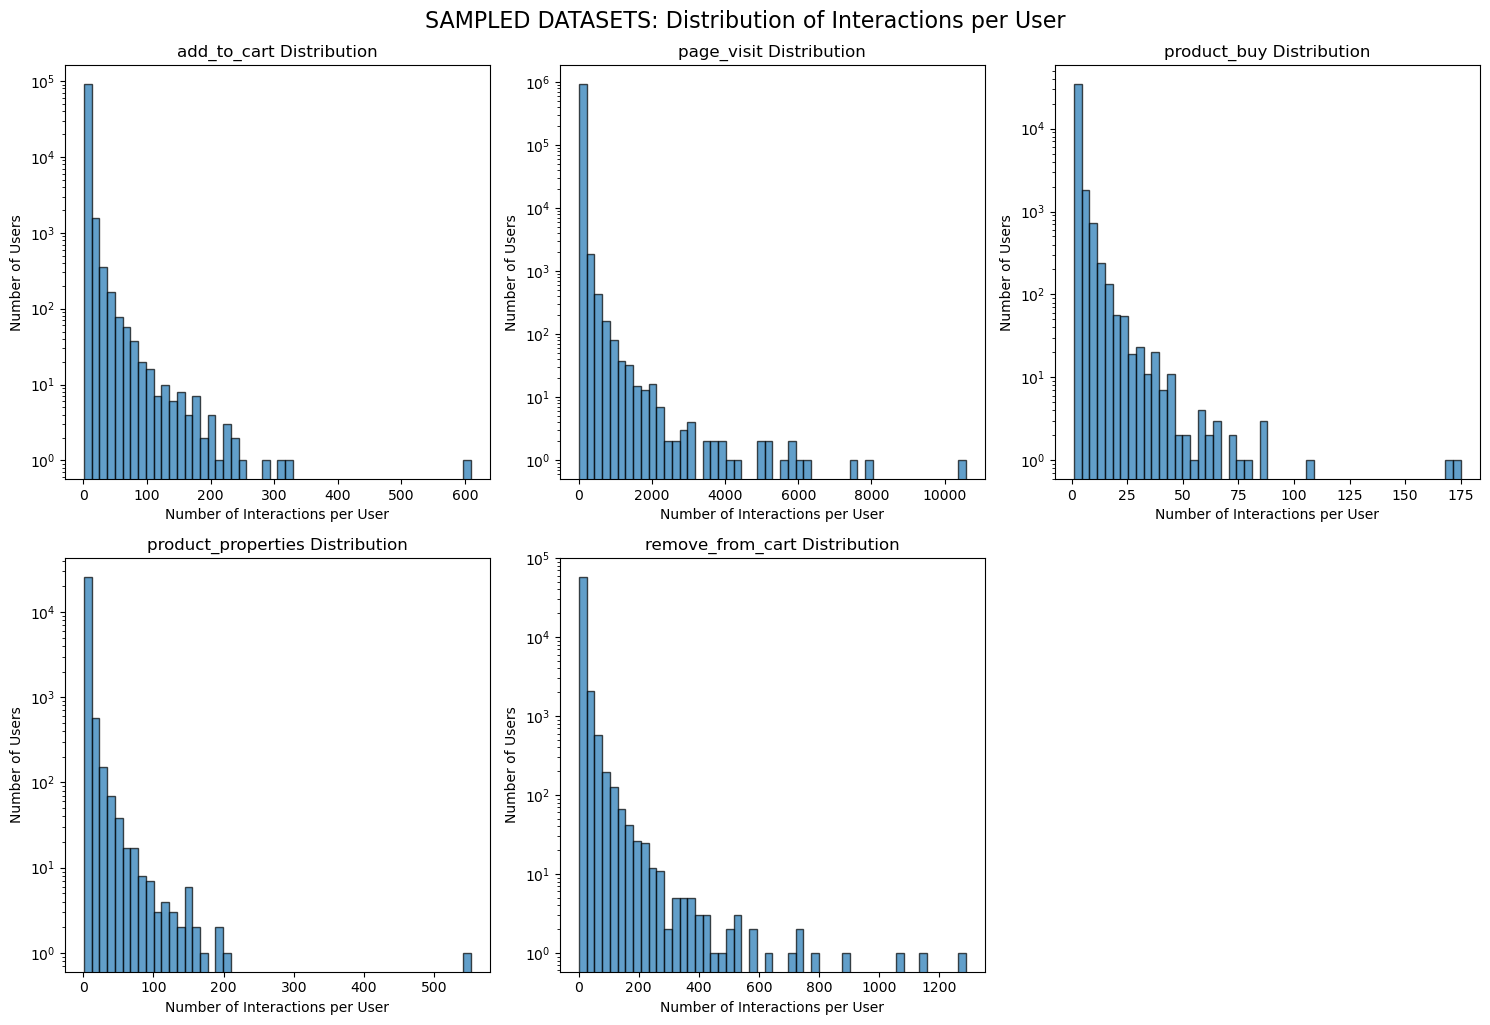

In [13]:

# Take random 5% of all unique users across all datasets
sample_fraction = 0.05
# Get all unique users across all datasets
all_users = full_recsys.all_users_set()
print(f"Total unique users across all datasets: {len(all_users):,}")
all_users = list(all_users)  # Convert to list for sampling

# Sample 5% of all users
np.random.seed(42)  # For reproducibility
sampled_users = np.random.choice(all_users, size=int(len(all_users) * sample_fraction), replace=False)
sampled_users_set = set(sampled_users)

sampled_recsys = full_recsys.sampled_subset(sampled_users)

sampled_recsys.print_datasets_stats_nicely("Sampled Datasets")

In [16]:
# Save the sampled data to parquet files
sampled_recsys.save_parquet('../ubc_data_sampled')

In [27]:
all_users = full_recsys.all_users_set()

def most_popular_users(data, percentage=0.1):
  interaction_datasets = ['add_to_cart', 'product_buy', 'remove_from_cart', 'search_query']
  all_interactions = []
  for dataset_name in interaction_datasets:
    dataset = full_recsys.datasets[dataset_name]
    all_interactions.append(dataset[['client_id']])

  # Concatenate all interactions and count per user
  all_interactions_df = pd.concat(all_interactions, ignore_index=True)
  user_interaction_counts = all_interactions_df.groupby('client_id').size().reset_index(name='total_interactions')

  # Sort users by total interaction count and get top 10%
  user_interaction_counts = user_interaction_counts.sort_values('total_interactions', ascending=False)
  top_10_percent_count = int(len(user_interaction_counts) * percentage)
  top_10_percent_users = user_interaction_counts.head(top_10_percent_count)['client_id'].tolist()

  print(f"Top 10% users with most interactions: {len(top_10_percent_users):,}")
  print(f"Interaction range for top 10%: {user_interaction_counts.iloc[0]['total_interactions']} to {user_interaction_counts.iloc[top_10_percent_count-1]['total_interactions']}")
  return top_10_percent_users

top_10_percent_users = most_popular_users(full_recsys, percentage=0.01)
# Create a new RecSysData instance with only the top 10% users
top_10_percent_recsys = full_recsys.sampled_subset(top_10_percent_users)
top_10_percent_recsys

Top 10% users with most interactions: 28,132
Interaction range for top 10%: 5760 to 70


RecSysData(
  add_to_cart=926572,
  page_visit=14475162,
  product_buy=235687,
  product_properties=388828,
  remove_from_cart=480546,
  search_query=2512183,
  all users: 28132,
  all products: 388828
  all urls: 2895390,
)

=== TOP 10% USERS DATASET STATISTICS ===

add_to_cart:
  Total interactions: 926,572
  Unique users: 27,070
  Average interactions per user: 34.23
  Average interactions squared per user: 3336.27
  Min interactions per user: 1
  Max interactions per user: 1,731
  Median interactions per user: 23.00
  Std interactions per user: 46.53
  Time range: 2022-05-23 00:10:15 to 2022-10-10 23:58:35
  Unique products: 360,911
  Average products per user: 24.97
  Average products squared per user: 1678.47
  Min products per user: 1
  Max products per user: 1,032
  Median products per user: 17.00
  Std products per user: 32.48

page_visit:
  Total interactions: 14,475,162
  Unique users: 28,057
  Average interactions per user: 515.92
  Average interactions squared per user: 730603.06
  Min interactions per user: 1
  Max interactions per user: 27,810
  Median interactions per user: 361.00
  Std interactions per user: 681.50
  Time range: 2022-05-23 00:10:10 to 2022-10-10 23:59:55

product_buy:
  Tot

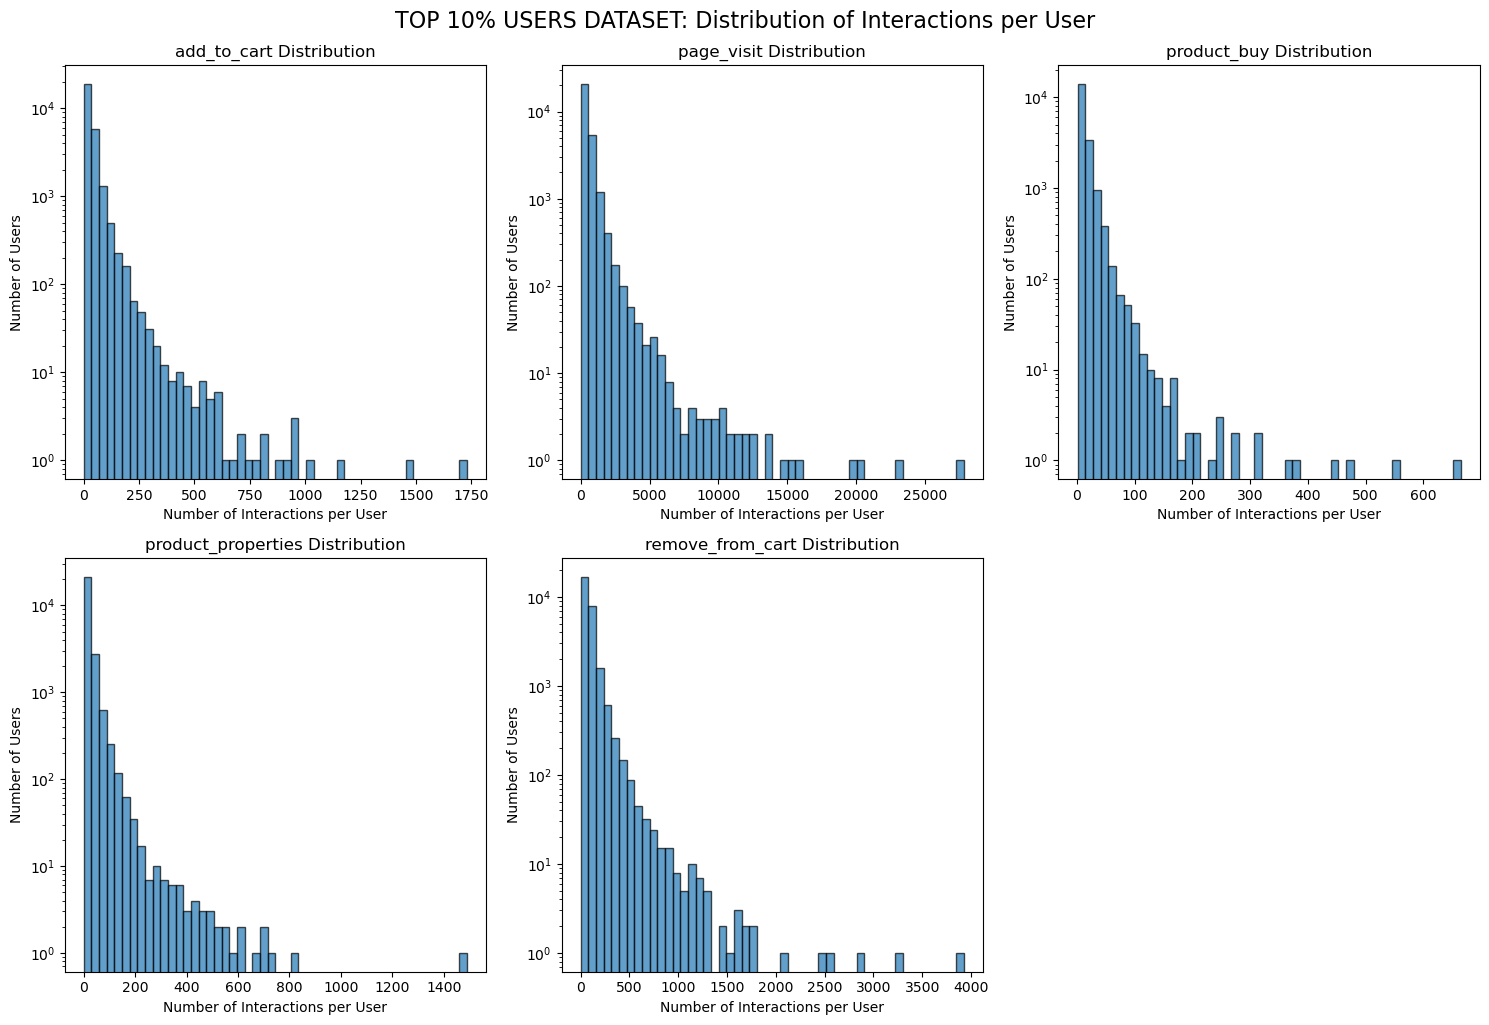

In [28]:
top_10_percent_recsys.print_datasets_stats_nicely("Top 10% Users Dataset")

In [48]:
unique_page_visits = full_recsys.page_visit.groupby('client_id')['url'].nunique()
print(f"  Average unique page visits per user: {unique_page_visits.mean():.2f}")
print(f"  Total unique page visits {unique_page_visits.sum()}")
print(f"  Average unique page visits squared per user: {(unique_page_visits ** 2).mean():.2f}")
print(f"  Max unique page visits per user: {unique_page_visits.max():,}")
print(f"  Median unique page visits per user: {unique_page_visits.median():.2f}")
print(f"  Std unique page visits per user: {unique_page_visits.std():.2f}")

  Average unique page visits per user: 3.79
  Total unique page visits 70636524
  Average unique page visits squared per user: 170.36
  Max unique page visits per user: 9,292
  Median unique page visits per user: 1.00
  Std unique page visits per user: 12.49


In [49]:
# Note: sum of squares of interaction counts (cost of attention)
# add_to_cart:
# >>> 1_900_000 * 62
# 117_800_000
# buy_product:
# >>> 750_860 * 19 
# 14_266_340
# remove_from_cart:
# >>> 530_000 * 75
# 39_750_000
# search_query:
# >>> 1_200_000 * 510
# 612_000_000
# >>> 18_000_000*1874
# 33_732_000_000
# 
# sum of squares of interaction counts without repetition:
# add_to_cart:
# >>> 1874391 * 32
# 59_980_512
# buy_product:
# >>> 750860 * 11
# 8_259_460
# remove_from_cart:
# >>> 536626 * 49
# 26_294_674
# search_query:
# __
# page_visit:
# >>> 18_000_000 * 170
# 3_164_499_340

# just number of interactions
# add_to_cart:
# 5_235_882
# buy_product:
# 1_682_296
# remove_from_cart:
# 1_697_891
# search_query:
# 9_571_258
# page_visit:
# 150_713_186

# just number of unique interactions (about 80%)
# add_to_cart:
# 4_067_613
# buy_product:
# 1_361_976
# remove_from_cart:
# 1_361_592
# search_query:
# __
# page_visit (50% !!!):
# 70_636_524

In [56]:
import numpy as np

# Load the relevant users from the numpy file
relevant_users = np.load('../ubc_data/input/relevant_clients.npy')

# Count the relevant users
relevant_users_count = len(relevant_users)

print(f"Number of relevant users: {relevant_users_count:,}")
print(f"Type: {type(relevant_users)}")
print(f"Data type: {relevant_users.dtype}")
print(f"Shape: {relevant_users.shape}")

# Show first few relevant user IDs
print(f"\nFirst 10 relevant users: {relevant_users[:10]}")

# Check if these users exist in our datasets
relevant_users_set = set(relevant_users)
overlap_with_all_users = len(relevant_users_set.intersection(all_users))
print(f"Percentage of relevant users in our data: {(overlap_with_all_users / relevant_users_count) * 100:.2f}%")

print(f"But still all_users in database counts {len(all_users):,} users")

Number of relevant users: 1,000,000
Type: <class 'numpy.ndarray'>
Data type: int64
Shape: (1000000,)

First 10 relevant users: [ 5963217 17797869 18408314 12045388 20673586  7663245 12227114 23087838
   778845  4709280]
Percentage of relevant users in our data: 100.00%
But still all_users in database counts 18,889,063 users


In [57]:
relevant_users_data = full_recsys.sampled_subset(relevant_users_set, reset_index=False)
relevant_users_data

RecSysData(
  add_to_cart=2654264,
  page_visit=41919050,
  product_buy=1218423,
  product_properties=831550,
  remove_from_cart=1138370,
  search_query=4212745,
  all users: 1000000,
  all products: 831550
  all urls: 6171078,
)

=== RELEVANT USERS DATASET STATISTICS ===

add_to_cart:
  Total interactions: 2,654,264
  Total users: 612,544
  Average interactions per user: 4.33
  Average interactions squared per user: 147.78
  Min interactions per user: 1
  Max interactions per user: 1,731
  Median interactions per user: 2.00
  Std interactions per user: 11.36
  Time range: 2022-05-23 00:10:15 to 2022-10-10 23:59:10
  Unique products: 716,619
  Product interactions: 1,944,294
  Average products per user: 3.17
  Average products squared per user: 74.39
  Min products per user: 1
  Max products per user: 1,032
  Median products per user: 1.00
  Std products per user: 8.02

page_visit:
  Total interactions: 41,919,050
  Total users: 844,923
  Average interactions per user: 49.61
  Average interactions squared per user: 24774.94
  Min interactions per user: 1
  Max interactions per user: 22,879
  Median interactions per user: 18.00
  Std interactions per user: 149.38
  Time range: 2022-05-23 00:10:05 to 2022-10-10 23

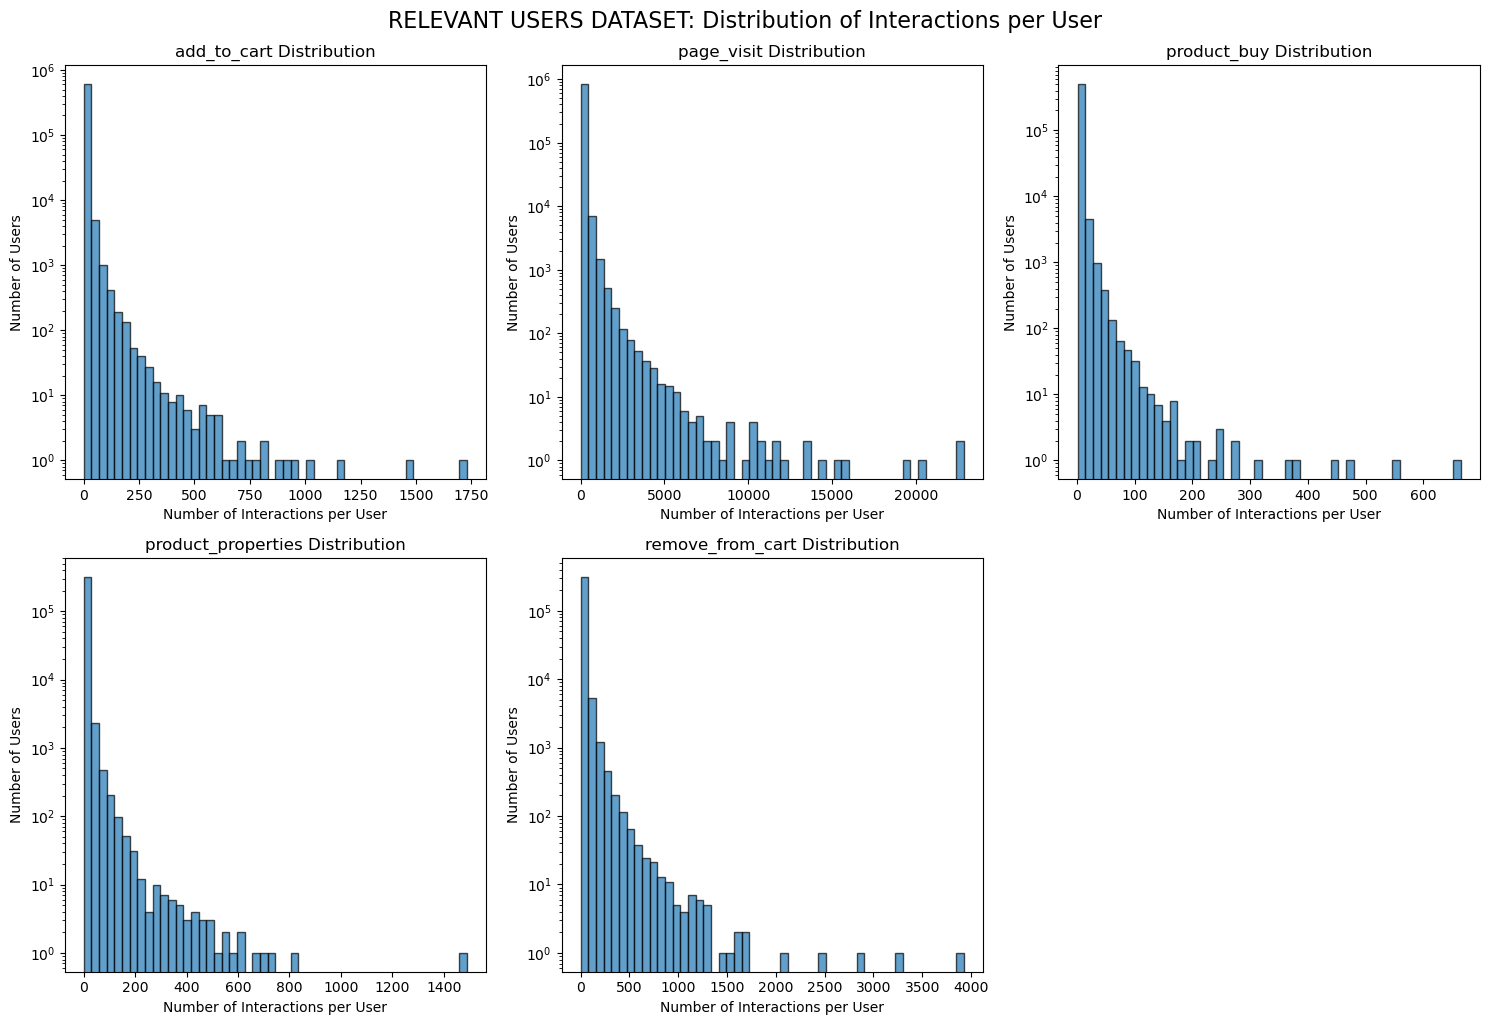

In [58]:
relevant_users_data.print_datasets_stats_nicely("Relevant Users Dataset")